In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils.load import load_raw_data_csv

### Load Data

In [ ]:
df = load_raw_data_csv("data/")
df.head()

### First Investigation
Check for the type of variables (contineous, categorical, etc.) and nan-values.

Results:
- It can be seen that circumplex.arousal and circumplex.valence are the only variables containing nan-values. Respectively about 1 and 3 percent of the total values for those variables.
- Some of the recorded screen times have negative values.
- Practically all variables related to screentime or activity have distributions skewed to the right. A possible solution might be transforming the data by taking the logarithm

In [103]:
for variable in df.variable.unique():
    values = df[df.variable == variable].value
    print(40*"%" + "\n" + variable + "\n", values.describe())

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
mood
 count    5641.000000
mean        6.992555
std         1.032769
min         1.000000
25%         7.000000
50%         7.000000
75%         8.000000
max        10.000000
Name: value, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
circumplex.arousal
 count    5597.000000
mean       -0.098624
std         1.051868
min        -2.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: value, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
circumplex.valence
 count    5487.000000
mean        0.687808
std         0.671298
min        -2.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: value, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
activity
 count    22965.000000
mean         0.115958
std          0.186946
min          0.000000
25%          0.000000
50%          0.021739
75%          0.158333
max          1.000000
Name: value, dty

In [104]:
nan_df = pd.DataFrame(columns=["nan-count", "nan-pct"])
for i, variable in enumerate(df.variable.unique()):
    values = df[df.variable == variable].value
    nan_count = values.isna().sum()
    nan_pct = nan_count / len(values)
    nan_df.loc[variable] = [nan_count, nan_pct]
    
# only print those variables with nonzero nan-values
nan_df[nan_df["nan-count"] != 0]

,nan-count,nan-pct
circumplex.arousal,46.0,0.008152
circumplex.valence,156.0,0.027645


mood
 7.0     2588
8.0     1429
6.0     1009
5.0      258
9.0      215
4.0       92
3.0       17
10.0      17
2.0       13
1.0        3
Name: value, dtype: int64
circumplex.arousal
  1.0    1654
-1.0    1612
 0.0    1586
-2.0     521
 2.0     224
Name: value, dtype: int64
circumplex.valence
  1.0    3595
 0.0    1307
-1.0     289
 2.0     265
-2.0      31
Name: value, dtype: int64
call
 1.0    5239
Name: value, dtype: int64
sms
 1.0    1798
Name: value, dtype: int64
Variable: activity


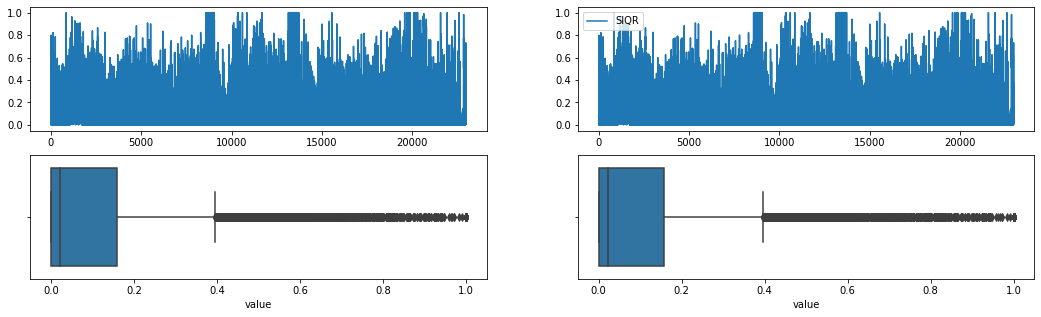

Variable: screen


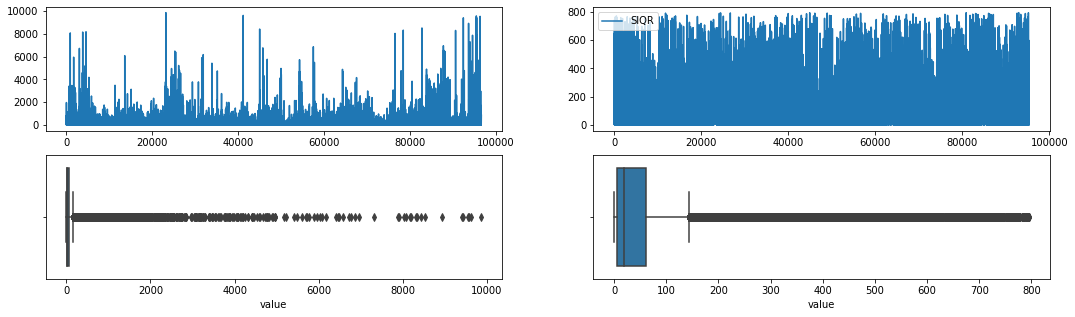

Variable: appCat.builtin


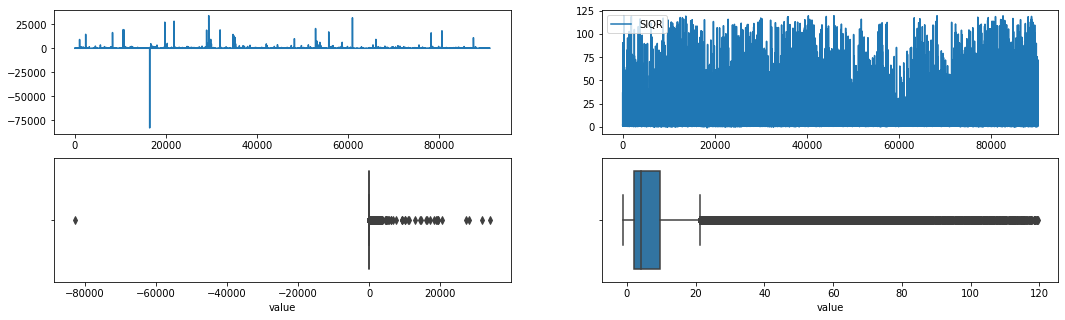

Variable: appCat.communication


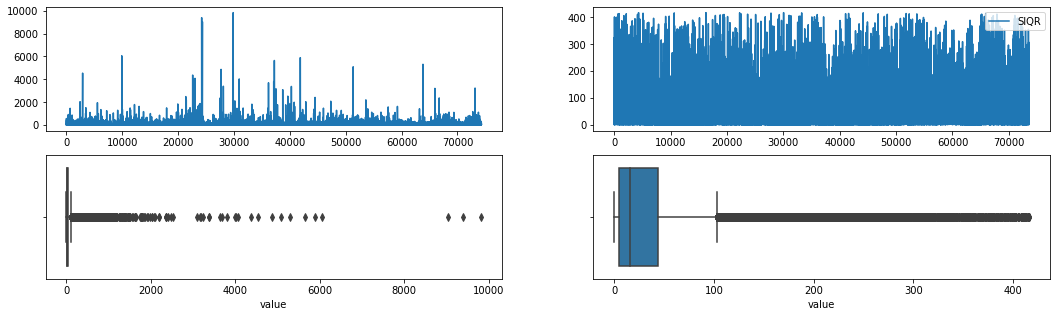

Variable: appCat.entertainment


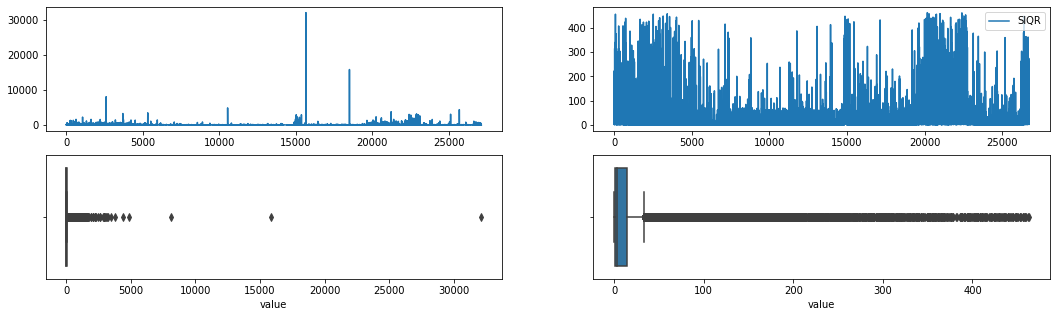

Variable: appCat.finance


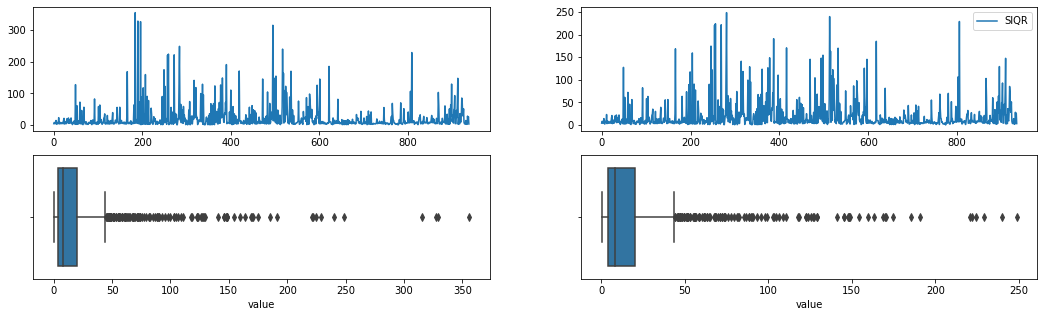

Variable: appCat.game


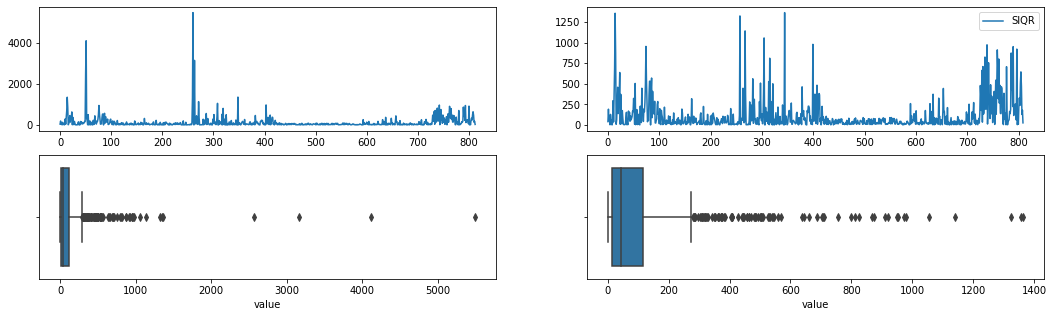

Variable: appCat.office


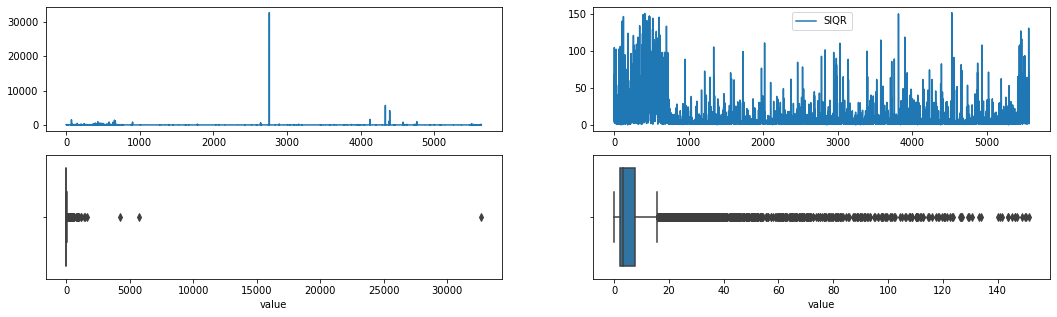

Variable: appCat.other


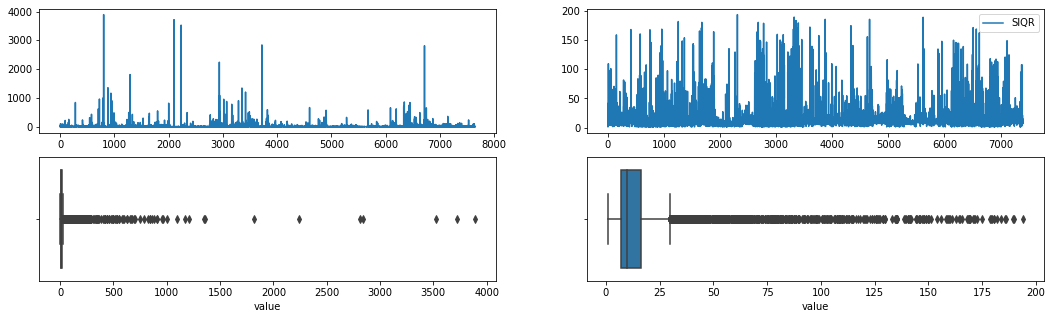

Variable: appCat.social


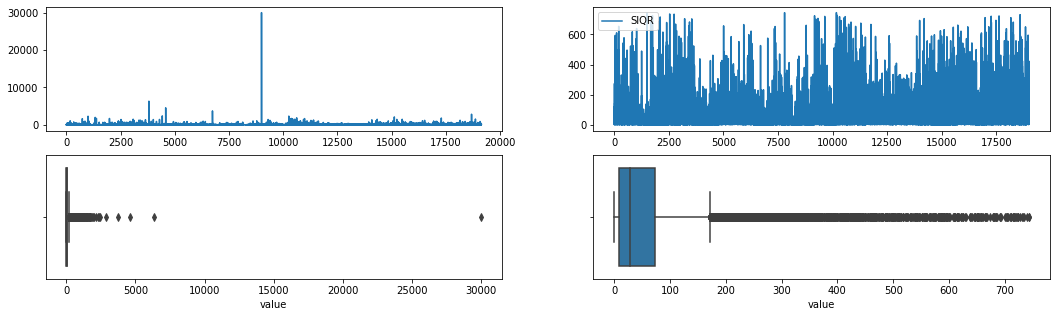

Variable: appCat.travel


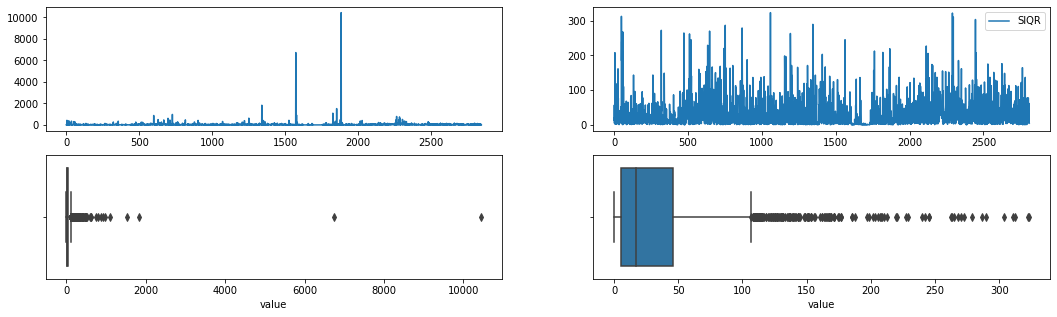

Variable: appCat.unknown


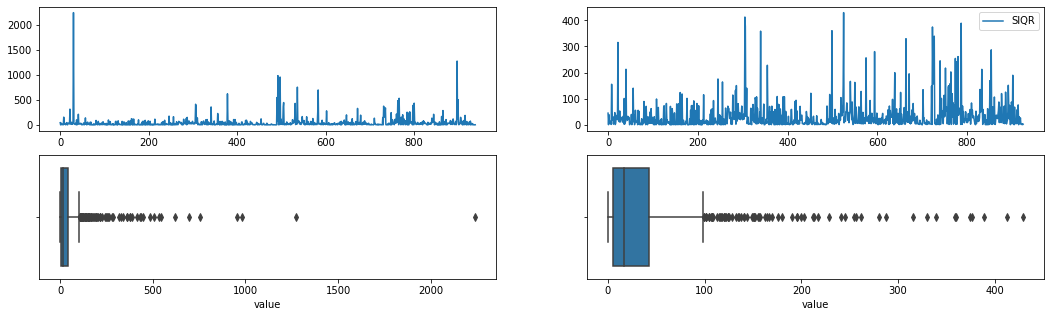

Variable: appCat.utilities


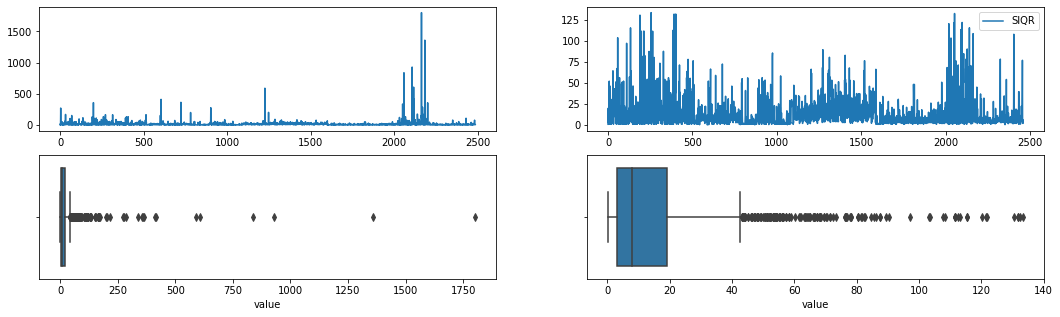

Variable: appCat.weather


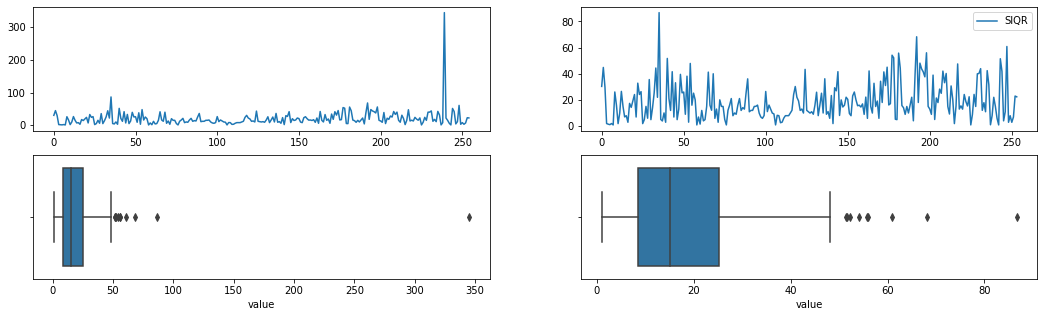

In [102]:
variables_to_plot_for = [var for var in list(df.variable.unique()) if "appCat." in var or var in ["screen", "activity"]]
variables_to_not_plot_for = set(df.variable.unique()) - set(variables_to_plot_for)

# for binary variables and/or limited to for example [-2,2]
for variable in variables_to_not_plot_for:
    print(variable + "\n", df[df.variable == variable].value.value_counts())

# all contineous variables (mostly screen time)
for variable in variables_to_plot_for:
    values = df[df.variable == variable].reset_index(drop=True).value
    data1 = sorted(values.values)
    q1 = np.percentile(data1, 25)
    q2 = np.percentile(data1, 50)
    q3 = np.percentile(data1, 95)

    values_outliers = values[~((values<(q2-3*(q2-q1))) | (values>(q2+3*(q3-q2))))].reset_index(drop=True)

    print('Variable: {}'.format(variable))
    fig, axs = plt.subplots(2,2, figsize=(18,5))
        
    # left plot
    ax = axs[0,0]
    # ax.set_title("")
    ax.plot(values, label='No correction')

    # right plot
    ax = axs[0,1]
    # ax.set_title("")
    ax.plot(values_outliers, label='SIQR')
    ax.legend()

    ax = axs[1,0]
    # ax.set_title("Boxplot all datapints")
    sns.boxplot(data=values, x=values, sym="red", ax=ax)

    ax = axs[1,1]
    sns.boxplot(data=values_outliers, x=values_outliers, ax=ax)

    for ax in axs:
        # ax.grid()
        # ax.set_title('{}'.format(var))
        pass
    plt.show()

### Simple Correlation Plots
Investigate the correlation between the variables. The values for each variables are aggregated by userId and date.
Then the correlation is computed. Nan-values are automatically ignored in this computation.
It can be seen that:
- screen time seems highly positively correlated to appCat.communication
- screen time is also positively correlated to gaming and social
- circumplex.valence is highly positvely correlated to mood
The aggregated variables related to screen time or call/sms are filled with nan-values. If these fields are not present for a full day, i.e. no screen time recorded, this implies zero.

type of aggregation: nansum


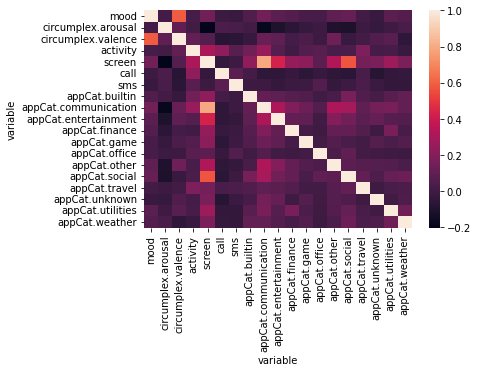

type of aggregation: mean


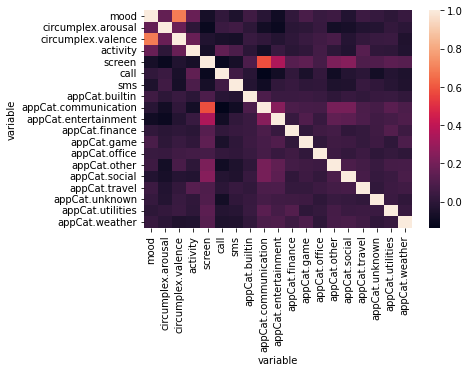

In [175]:
df_pivot = pd.pivot_table(df, values='value', index=['id', 'date'],
                                columns=['variable'], aggfunc=[np.nansum, np.mean, "count"]).reset_index()
for multi_index in ["nansum", "mean"]:
    for column in df_pivot[multi_index].columns:
        if "appCat." in column or column in ["screen", "call", "sms"]:
            df_pivot[multi_index, column] = df_pivot[multi_index, column].fillna(0)
            
# plot correlation map
for type_of_agg in ["nansum", "mean"]:
    print("type of aggregation: " + type_of_agg)
    r = df_pivot[[[type_of_agg,c] for c in df.variable.unique()]][type_of_agg]
    sns.heatmap(r.corr())
    plt.show()

In [158]:
for i in range(1, 10):
    try:
        print(df_pivot[df_pivot.id == f"AS14.0{i}"].date.diff().max())
    except:
        pass

3 days 00:00:00
1 days 00:00:00
2 days 00:00:00
nan
3 days 00:00:00
3 days 00:00:00
1 days 00:00:00
7 days 00:00:00
4 days 00:00:00


In [159]:
for i in range(10, 40):
    try:
        print(df_pivot[df_pivot.id == f"AS14.{i}"].date.diff().max())
    except:
        pass

nan
nan
4 days 00:00:00
4 days 00:00:00
3 days 00:00:00
2 days 00:00:00
3 days 00:00:00
2 days 00:00:00
nan
4 days 00:00:00
4 days 00:00:00
nan
nan
6 days 00:00:00
1 days 00:00:00
3 days 00:00:00
2 days 00:00:00
3 days 00:00:00
8 days 00:00:00
6 days 00:00:00
3 days 00:00:00
2 days 00:00:00
2 days 00:00:00
2 days 00:00:00
nan
nan
nan
nan
nan
nan


(array([1.000e+00, 8.560e+02, 7.960e+02, 1.453e+03, 1.405e+03, 1.757e+03,
        1.779e+03, 2.164e+03, 2.058e+03, 8.610e+02]),
 array([-5.46383181, -4.91744862, -4.37106544, -3.82468226, -3.27829908,
        -2.7319159 , -2.18553272, -1.63914954, -1.09276636, -0.54638318,
         0.        ]),
 <BarContainer object of 10 artists>)

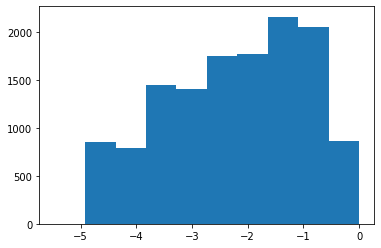

In [160]:
values = df[df.variable == "activity"].value
plt.hist(np.log(values[values != 0]))

activity


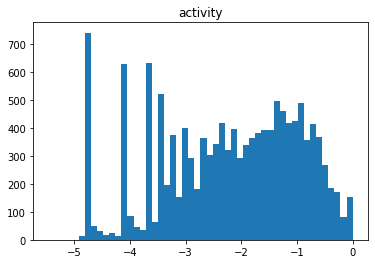

screen


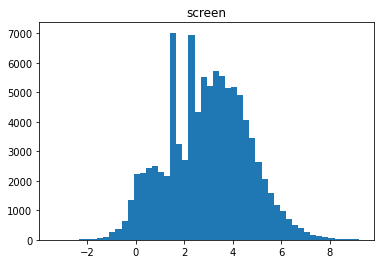

appCat.builtin


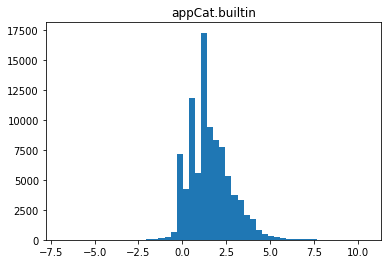

appCat.communication


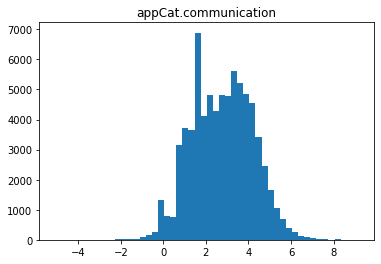

appCat.entertainment


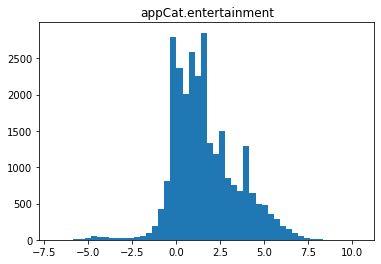

appCat.finance


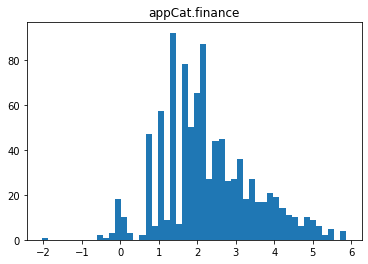

appCat.game


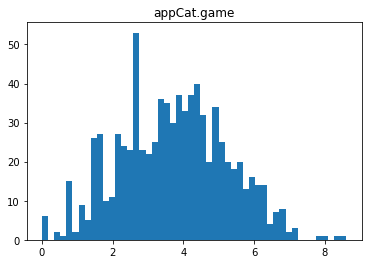

appCat.office


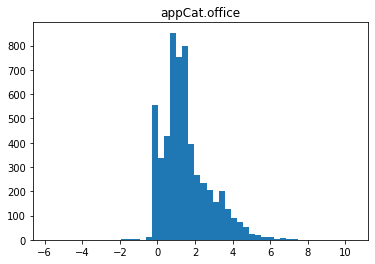

appCat.other


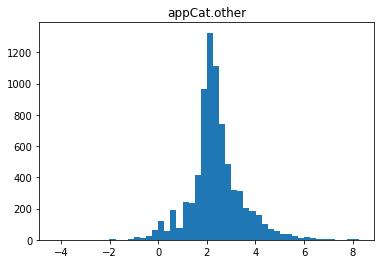

appCat.social


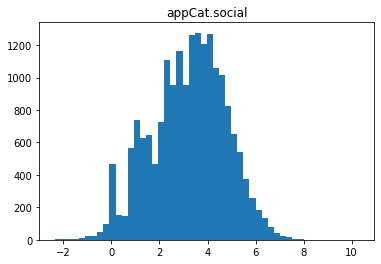

appCat.travel


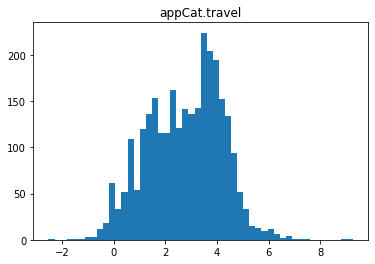

appCat.unknown


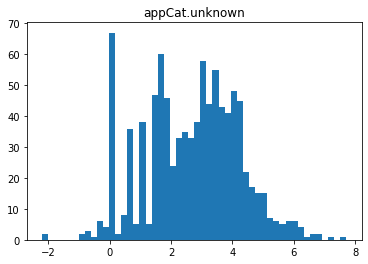

appCat.utilities


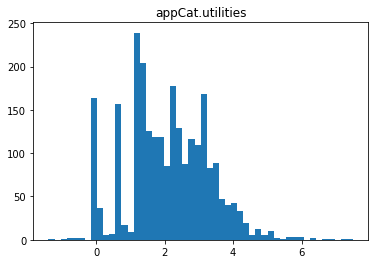

appCat.weather


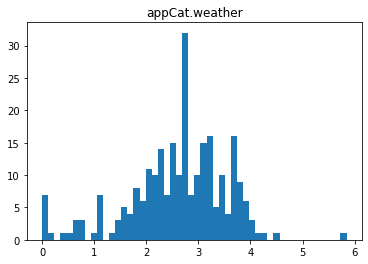

In [161]:
for variable in df.variable.unique():
    if "appCat." in variable or variable in ["screen", "activity"]:
        print(variable)
        values = df[df.variable == variable].value
        values = values.dropna()
        plt.title(variable)
        plt.hist(np.log(values[values > 0]), bins = 50)
        plt.show()

In [162]:
df[df.variable == "circumplex.arousal"].value.isna()

5641     False
5642     False
5643     False
5644     False
5645     False
         ...  
11279    False
11280    False
11281    False
11282    False
11283    False
Name: value, Length: 5643, dtype: bool

In [173]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(5)
from statsmodels.graphics.tsaplots import plot_acf



In [165]:
df_pivot["nansum", "circumplex.arousal"].isna().sum()

705

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


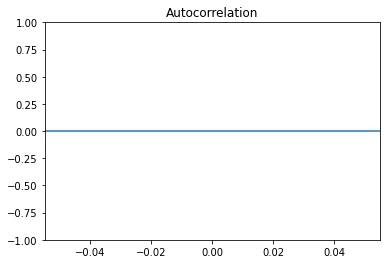

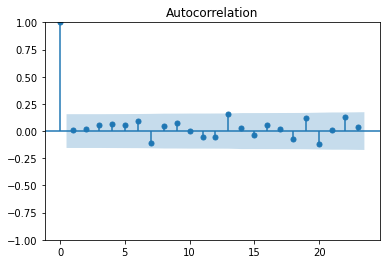

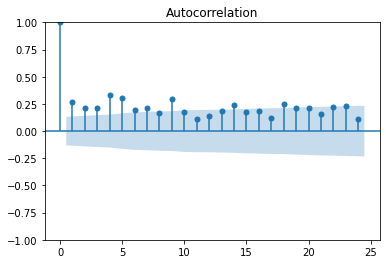

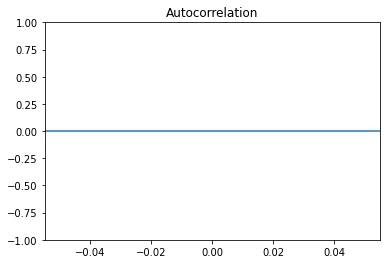

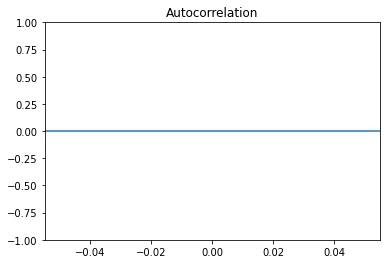

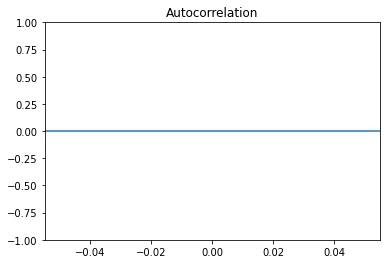

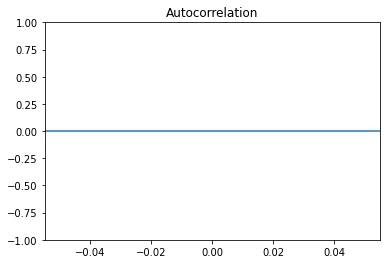

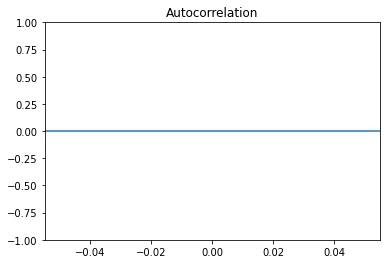

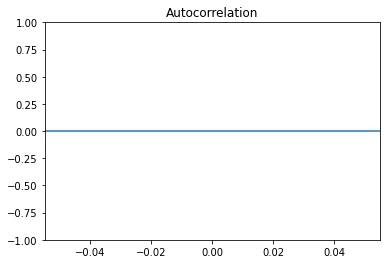

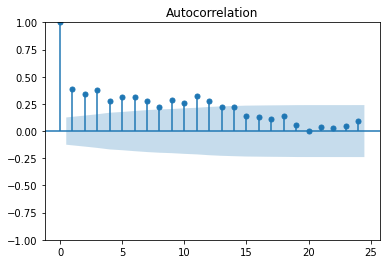

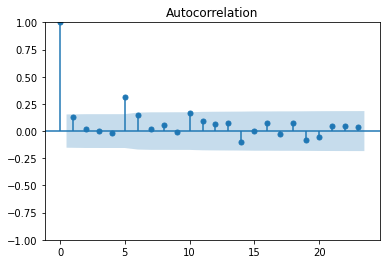

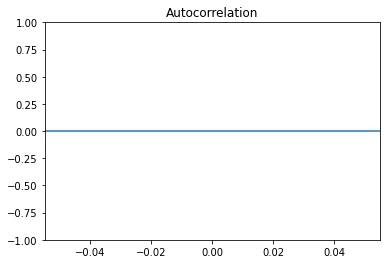

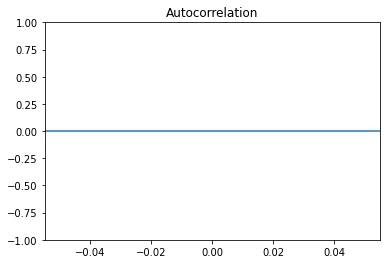

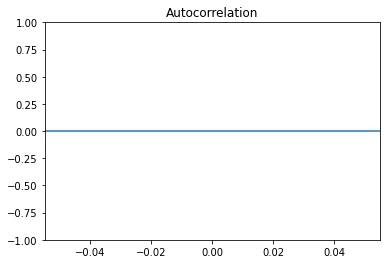

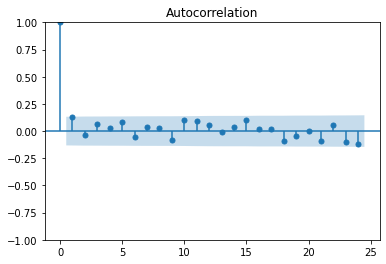

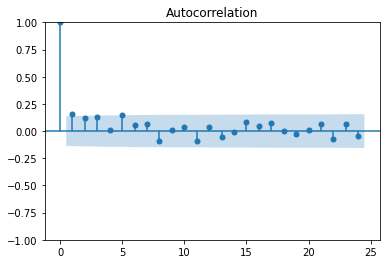

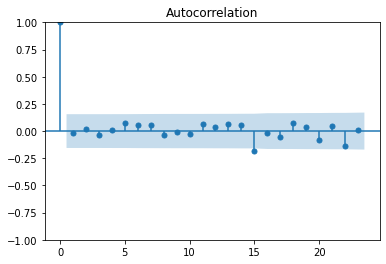

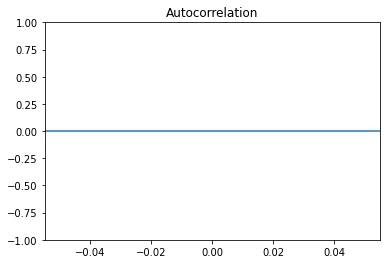

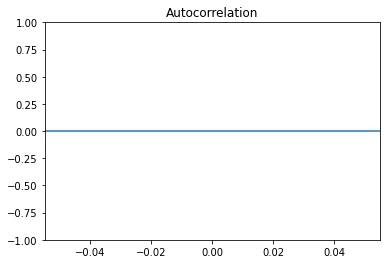

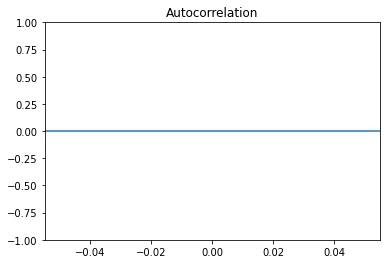

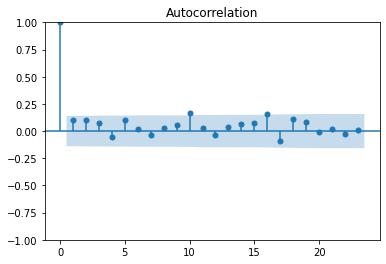

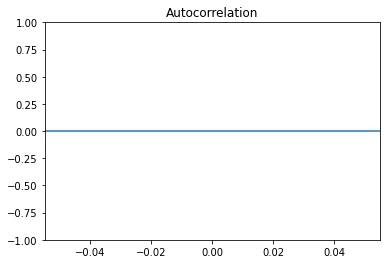

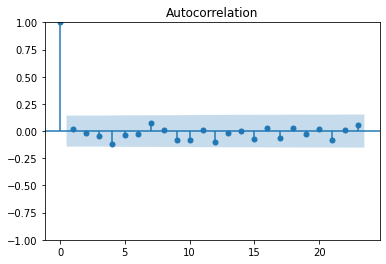

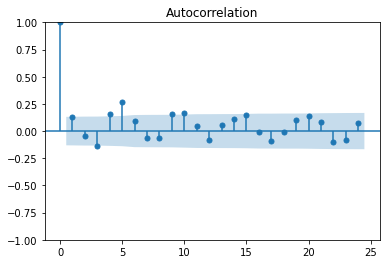

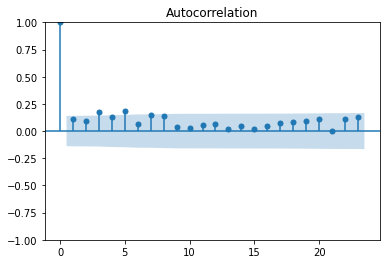

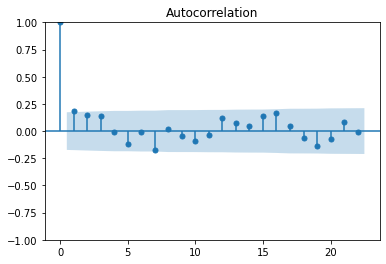

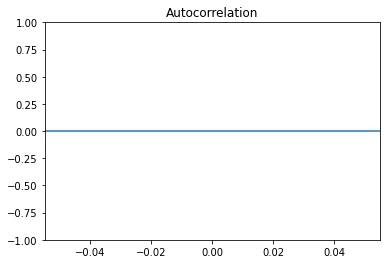

In [172]:
ids = df.id.unique()

for id in ids:
    values = df[(df.variable == "circumplex.arousal") & (df.id == id)]
    plot_acf(values.value.values)
    plt.show()

In [167]:
ids

array(['AS14.01', 'AS14.02', 'AS14.03', 'AS14.05', 'AS14.06', 'AS14.07',
       'AS14.08', 'AS14.09', 'AS14.12', 'AS14.13', 'AS14.14', 'AS14.15',
       'AS14.16', 'AS14.17', 'AS14.19', 'AS14.20', 'AS14.23', 'AS14.24',
       'AS14.25', 'AS14.26', 'AS14.27', 'AS14.28', 'AS14.29', 'AS14.30',
       'AS14.31', 'AS14.32', 'AS14.33'], dtype=object)

In [179]:
df_pivot["count"]["circumplex.arousal"].value_counts()

5.0    769
4.0    309
3.0     85
2.0     61
1.0     25
6.0     19
Name: circumplex.arousal, dtype: int64

In [181]:
t = pd.DataFrame({"variable": ["v1", "v1", "v2", "v2"], "value": [np.nan, 1, 2, 3]})
t.pivot_table(values="value", columns="variable", aggfunc=["count"])

count   
variable    v1 v2
value        1  2

In [189]:
for id in ids:
    for column in df.variable.unique():
        val = df[(df.id == id) & (df.variable == column)].dropna()
        if len(val) == 0:
            print(id, column)
    # print(id, column, len(df[(df.id == id) & (df.variable == "circumplex.arousal")]))

AS14.02 appCat.finance
AS14.02 appCat.game
AS14.02 appCat.office
AS14.02 appCat.unknown
AS14.02 appCat.weather
AS14.03 appCat.game
AS14.05 appCat.finance
AS14.05 appCat.game
AS14.05 appCat.weather
AS14.06 appCat.finance
AS14.06 appCat.utilities
AS14.07 appCat.finance
AS14.07 appCat.office
AS14.07 appCat.weather
AS14.08 appCat.finance
AS14.08 appCat.game
AS14.08 appCat.weather
AS14.13 appCat.finance
AS14.13 appCat.game
AS14.13 appCat.weather
AS14.14 appCat.weather
AS14.15 appCat.game
AS14.15 appCat.weather
AS14.16 appCat.office
AS14.17 appCat.weather
AS14.19 appCat.finance
AS14.19 appCat.office
AS14.19 appCat.weather
AS14.20 appCat.office
AS14.20 appCat.weather
AS14.23 appCat.finance
AS14.23 appCat.weather
AS14.24 appCat.finance
AS14.24 appCat.game
AS14.24 appCat.weather
AS14.26 appCat.finance
AS14.26 appCat.game
AS14.27 appCat.finance
AS14.27 appCat.unknown
AS14.29 appCat.game
AS14.29 appCat.unknown
AS14.29 appCat.weather
AS14.31 appCat.game
AS14.31 appCat.weather
AS14.32 appCat.financ

In [188]:
df[(df.id == "AS14.02") & (df.variable == "")].dropna()

,id,time,variable,value,date
5864,AS14.02,2014-03-16 15:00:00,circumplex.arousal,0.0,2014-03-16
5865,AS14.02,2014-03-16 18:00:00,circumplex.arousal,-1.0,2014-03-16
5866,AS14.02,2014-03-16 21:00:00,circumplex.arousal,1.0,2014-03-16
5867,AS14.02,2014-03-17 09:00:00,circumplex.arousal,0.0,2014-03-17
5868,AS14.02,2014-03-17 12:00:00,circumplex.arousal,2.0,2014-03-17
...,...,...,...,...,...
6018,AS14.02,2014-04-23 09:00:00,circumplex.arousal,-1.0,2014-04-23
6019,AS14.02,2014-04-23 21:00:00,circumplex.arousal,1.0,2014-04-23
6020,AS14.02,2014-04-24 16:00:00,circumplex.arousal,-1.0,2014-04-24
6021,AS14.02,2014-04-24 21:00:00,circumplex.arousal,0.0,2014-04-24


In [198]:
df[(df.variable == "activity") & (df.id == "AS14.01")].time

16927   2014-03-20 22:00:00
16928   2014-03-20 23:00:00
16929   2014-03-21 00:00:00
16930   2014-03-21 01:00:00
16931   2014-03-21 02:00:00
                ...        
17978   2014-05-05 06:00:00
17979   2014-05-05 07:00:00
17980   2014-05-05 08:00:00
17981   2014-05-05 09:00:00
17982   2014-05-05 10:00:00
Name: time, Length: 1056, dtype: datetime64[ns]